In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,date
from pandas.tseries.holiday import USFederalHolidayCalendar
import os

In [2]:
base_path_DPMU = "..\\..\\data\\summer\\targets\\trimmed_targets"
all_months_DPMU = {} ##{mm:{a:, b:, c:}, mm:{a:,b:,c:}}

include_kmeans = 0
include_PCA = 1
include_holidays = 0
include_wknds = 0
include_dayofweek = 0
include_phase = 0
%store include_kmeans
%store include_PCA
%store include_holidays
%store include_wknds
%store include_dayofweek
%store include_phase

Stored 'include_kmeans' (int)
Stored 'include_PCA' (int)
Stored 'include_holidays' (int)
Stored 'include_wknds' (int)
Stored 'include_dayofweek' (int)
Stored 'include_phase' (int)


# Input (DPMU) Preprocessing (sends to X.csv)

In [3]:
#modifies raw (trimmed) csv to add time features and process the various phases/houses
def modify_csv(month_phase_csv, month_func, year_user):
    ##time modifications
    month_fill = 0
    if month_func == 'june':
        month_fill = 6
    elif month_func == 'july':
        month_fill = 7
    elif month_func == 'aug':
        month_fill = 8
    elif month_func == 'sept':
        month_fill = 9
    time = month_phase_csv['# timestamp']
    time = pd.Series(time)
    time = time.str.split(" ")
    for index in range(len(time)):
        del time[index][2]
    time
    month = []
    hour = []
    for index in range(len(time)):
        month.append(datetime.strptime(time[index][0],'%Y-%m-%d'))
        hour.append(datetime.strptime(time[index][1],'%H:%M:%S'))
    date = []
    timestamp = []

    for index in range(len(time)):
        for jindex in range(len(time[index])):
            if "-" in time[index][jindex]:
                date.append(time[index][jindex].split("-"))
            if ":" in time[index][jindex]:
                timestamp.append(time[index][jindex].split(":"))
    date = np.array(date)
    timestamp = np.array(timestamp)
    #separating the individual values into different list
    year = []
    month = []
    day = []
    for y in range(len(date)):
        year.append(date[y][0])
        month.append(date[y][1])
        day.append(date[y][2])

    #do special processing for the hours and minutes
    day_min = []
    for y in range(len(timestamp)):
        hour_min_added = int(timestamp[y][0]) * 60
        hour_min_added = hour_min_added + int(timestamp[y][1])
        day_min.append(hour_min_added) 

    ##code to overwrite 'January' outputs for csv's    
    year = [year_user] * len(date)
    month = [month_fill] * len(date)
        
    time_df = pd.DataFrame()
    time_df["year"] = year
    time_df["month"] = month
    time_df["day"] = day
    

    time_df["hour_min"] = day_min
        
    month_phase_mod = month_phase_csv.drop(['Meter5', '# timestamp'], axis=1)
    month_phase_mod = pd.concat([month_phase_mod,time_df], axis=1)
    #print (month_phase_mod)
    return month_phase_mod

In [4]:
#modifies the global all_months_DPMU. When this is over, that array will have all the necessary information to be concatenated into a giant array.
def sep_DPMU_features():
    #print (base_path_DPMU)
    for month in os.listdir(base_path_DPMU):
        month_path = os.path.join(base_path_DPMU,month)
        month_dict = {}
        for multi_voltage_output in os.listdir(month_path):
            full_csv_path = os.path.join(month_path,multi_voltage_output)
            #print(full_csv_path)
            cut_voltage = multi_voltage_output[:-4]
            #print(cut_voltage)
            letter = cut_voltage[-1:]
            #print(letter)
            dpmu_phase_month = "dpmu_phase" + letter + "_" + month
            raw_csv = pd.read_csv(full_csv_path)
            month_dict[letter] = modify_csv(raw_csv, month, 2018)
        #add month dictionary
        all_months_DPMU[month]=month_dict
    #return all the months it found in the base dir
    return list(all_months_DPMU.keys())
    

In [5]:
def DPMU(phase, dpmu_data, letter):
    phase_letter = ord(letter) - 65
    #print(phase_letter)
    for (columnName, columnData) in phase.iteritems():
        i=0
        if 'Meter' in columnName: ##meters
            split = columnName.split('Meter')
            house_name = f'Meter{letter}_'+ split[1]
            i+=1
            dpmu_values = pd.Series(columnData.values).str.replace("i", "j").apply(lambda x: abs(complex(x)))
            dpmu_data[house_name] = dpmu_values
        elif 'node' in columnName : ##nodes
            split_column_names = columnName.split('_')
            house_name = 'house'+str(split_column_names[phase_letter])
            dpmu_values = pd.Series(columnData.values).str.replace("i", "j").apply(lambda x: abs(complex(x)))
            dpmu_data[house_name] = dpmu_values
        else: ##timestamps, day_min
            if letter == 'A':
                dpmu_data[columnName] = pd.Series(columnData.values)
    return dpmu_data
    

In [31]:
def concat_all_DPMU():
    all_months_to_concat = []
    
    for month in all_months_DPMU:
        #print(month)
        dpmu_data_month = pd.DataFrame()
        for phase in all_months_DPMU[month]:
            #print (phase)
            dpmu_data_month = DPMU(all_months_DPMU[month][phase.upper()], dpmu_data_month, phase.upper())
        all_months_to_concat.append(dpmu_data_month)
    input_dataframe_DPMU = pd.DataFrame() ##concatenates all months, directly to input
    input_dataframe_DPMU = pd.concat(all_months_to_concat, ignore_index = True)
    
#     input_dataframe_DPMU2 = pd.DataFrame()
#     for i in input_dataframe_DPMU:
#         if i == "hour_min" or i == 'year' or i == "month" or i =="day":
#             values = pd.Series(input_dataframe_DPMU[i].values)
#             input_dataframe_DPMU2 = input_dataframe_DPMU2.append(values, ignore_index = True)
#         else:
#             columns = input_dataframe_DPMU[i]
#             scaled_values = pd.Series(columns.values/2400)
#             #print(scaled_values)
#             input_dataframe_DPMU2 = input_dataframe_DPMU2.append(scaled_values, ignore_index = True)
    return (input_dataframe_DPMU)
    
        

In [7]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
def sep_DPMU_clusters_kmeans(): #simoni
    # determined convergence to be 5 clusters .. see png
    #sum_of_squared_distances = []
    #K = range(1,37)
    #for k in K:
    #    print(k)
    #    k_means = KMeans(n_clusters=k)
    #    model = k_means.fit(in_csv)
    #    sum_of_squared_distances.append(k_means.inertia_)
    #    print(k_means.inertia_)
    #plt.plot(K, sum_of_squared_distances, 'bx-')
    #plt.xlabel('k')
    #plt.ylabel('sum_of_squared_distances')
    #plt.title('elbow method for optimal k')
    #plt.show()
    kmeans_df = in_csv
    k_means = KMeans(n_clusters=5)
    model = k_means.fit(kmeans_df)
    #labels = k_means.labels_
    #print(metrics.silhouette_score(kmeans_df, labels, metric = 'euclidean'))
    #print(metrics.calinski_harabasz_score(kmeans_df, labels))

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def sep_DPMU_clusters_PCA(): #simoni
    pca_df = in_csv
    pca = PCA(n_components=37) # set to max components to determine convergence
    pca.fit(pca_df)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance') # returns that best # of components for convergence is ~10

In [9]:
def phase_clustering(): #swetha
    print(in_csv)
    #only keep one house/meter from each phase
    in_csv.drop(in_csv.columns.difference(['MeterA_1', 'MeterB_1', 'MeterC_1', 'housenode1', 'housenode2', 'housenode3', 'year',
                                          'month', 'day', 'hour_min']), 1, inplace=True)
    #print phase_clustering_df

    

In [10]:
#return df modified to include flags for holidays
def add_holidays(): #swetha
    print(in_csv)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2018-01-01', end='2018-12-31').to_pydatetime()

    holiday_array = []
    for i in range((in_csv.shape[0])):
        if datetime(int(in_csv.loc[in_csv.index[i], 'year']),
                   int(in_csv.loc[in_csv.index[i], 'month']),
                   int(in_csv.loc[in_csv.index[i], 'day'])) in holidays:
            holiday_array.append(1)
        else:
            holiday_array.append(0)
            
    in_csv["is_holiday"] = holiday_array


In [11]:
#return df modified to include flags for weekend
def add_weekends(): #swetha

    wknd_array = []
    for i in range((in_csv.shape[0])):
        wkday = date(int(in_csv.loc[in_csv.index[i], 'year']),
                   int(in_csv.loc[in_csv.index[i], 'month']),
                   int(in_csv.loc[in_csv.index[i], 'day'])).weekday()
        is_wknd = 1 if wkday>=4 else 0
        wknd_array.append(is_wknd)
    in_csv["is_weekend"] = wknd_array


In [12]:
#return df modified to include flags for weekend
def add_dayofweek(): #swetha

    wk_array = []
    for i in range((in_csv.shape[0])):
        wkday = date(int(in_csv.loc[in_csv.index[i], 'year']),
                   int(in_csv.loc[in_csv.index[i], 'month']),
                   int(in_csv.loc[in_csv.index[i], 'day'])).isoweekday()
        wk_array.append(wkday)

    in_csv["day_of_week"] = wk_array


In [13]:
##all_months_DPMU will have a dictionary of csv's for each month, each phase
sep_DPMU_features()

['aug', 'july', 'june', 'sept']

In [32]:
##input_dataframe_DPMU will have large dataframe of input data
send_input_to_csv = pd.DataFrame()
send_input_to_csv = concat_all_DPMU()

In [33]:
send_input_to_csv

,MeterA_2,MeterA_1,MeterA_3,MeterA_4,housenode1,housenode4,housenode7,housenode13,housenode10,housenode22,...,MeterC_3,MeterC_4,house3,house6,house9,house15,house12,house24,house21,house18
0,2376.409889,2378.388636,2361.400016,2357.538734,2363.994761,2376.991693,2375.718498,2352.767045,2361.400016,2361.418434,...,2347.430794,2343.286737,2366.926658,2366.504003,2366.229047,2337.377650,2347.430794,2344.827519,2347.430794,2342.868207
1,2380.907281,2382.797347,2371.481343,2369.147260,2369.150113,2380.564999,2378.824397,2364.411194,2371.481343,2371.381328,...,2350.315321,2346.584561,2368.194516,2368.069600,2367.731763,2340.824483,2350.315321,2347.744618,2350.315321,2346.217019
2,2377.256861,2379.415364,2366.150157,2362.635628,2365.298299,2377.165092,2375.486746,2355.295777,2366.150157,2365.965524,...,2347.366674,2343.390828,2368.214272,2367.751656,2367.378270,2337.614698,2347.366674,2344.726159,2347.366674,2343.008353
3,2374.778306,2376.835701,2360.276611,2355.968593,2363.462683,2374.634968,2372.936101,2347.306906,2360.276611,2360.103638,...,2346.915101,2342.973333,2368.147718,2367.509425,2367.188528,2337.128129,2346.915101,2344.249188,2346.915101,2342.826055
4,2374.294670,2376.486046,2360.364542,2356.340245,2361.685581,2374.155190,2372.415367,2348.156111,2360.364542,2360.259043,...,2350.219551,2346.321728,2370.321920,2369.072138,2368.743645,2340.504174,2350.219551,2347.680284,2350.219551,2346.162014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175675,2383.647127,2383.949621,2364.816449,2361.909454,2381.794340,2384.738434,2384.456407,2357.466568,2364.816449,2365.072928,...,2387.879512,2387.002581,2389.002002,2388.000478,2388.188000,2385.968149,2387.879512,2387.750663,2387.879512,2386.800404
175676,2384.341416,2384.643960,2366.016259,2363.111796,2382.212336,2385.452623,2385.210038,2358.636611,2366.016259,2366.251903,...,2381.532573,2380.660222,2385.728215,2384.553452,2384.738626,2379.636839,2381.532573,2381.440251,2381.523886,2380.458055
175677,2388.071887,2388.354823,2373.152195,2370.222813,2385.795089,2389.302478,2389.148854,2365.685649,2373.152195,2373.062116,...,2370.071818,2369.202664,2379.323677,2378.633987,2378.813187,2368.182870,2370.071818,2369.865101,2370.063124,2369.014147
175678,2388.068581,2388.391098,2373.609684,2370.815485,2385.984918,2389.277919,2389.113869,2366.339327,2373.609684,2373.440121,...,2366.610109,2365.695425,2378.270558,2377.354002,2377.516891,2364.671980,2366.610109,2366.403122,2366.610109,2365.488313


In [34]:
list(send_input_to_csv.columns)

['MeterA_2',
 'MeterA_1',
 'MeterA_3',
 'MeterA_4',
 'housenode1',
 'housenode4',
 'housenode7',
 'housenode13',
 'housenode10',
 'housenode22',
 'housenode19',
 'housenode16',
 'year',
 'month',
 'day',
 'hour_min',
 'MeterB_2',
 'MeterB_1',
 'MeterB_3',
 'MeterB_4',
 'house2',
 'house5',
 'house8',
 'house14',
 'house11',
 'house23',
 'house20',
 'house17',
 'MeterC_2',
 'MeterC_1',
 'MeterC_3',
 'MeterC_4',
 'house3',
 'house6',
 'house9',
 'house15',
 'house12',
 'house24',
 'house21',
 'house18']

In [35]:
send_input_to_csv = send_input_to_csv[['MeterA_1', 'MeterA_2', 'MeterA_3', 
                                       'MeterB_1', 'MeterB_2', 'MeterB_3',
                                      'MeterC_1', 'MeterC_2', 'MeterC_3',
                                      'housenode1','housenode4','housenode7',
                                       'housenode13','housenode10','housenode22',
                                       'housenode19','housenode16',
                                      'house2','house5', 'house8','house14',
                                       'house11','house23','house20','house17',
                                       'house3','house6','house9','house15','house12',
                                       'house24','house21','house18',
                                       'year','month','day','hour_min']]

# No clustering

In [18]:
in_csv = pd.DataFrame()
in_csv = send_input_to_csv.copy()
send_input_to_csv.to_csv('../../data/input/X.csv')

In [20]:
in_csv

,MeterA_1,MeterA_2,MeterA_3,MeterB_1,MeterB_2,MeterB_3,MeterC_1,MeterC_2,MeterC_3,housenode1,...,house9,house15,house12,house24,house21,house18,year,month,day,hour_min
0,2378.388636,2376.409889,2361.400016,2408.966692,2409.306509,2418.908502,2370.972273,2370.216064,2347.430794,2363.994761,...,2366.229047,2337.377650,2347.430794,2344.827519,2347.430794,2342.868207,2018,8,01,0
1,2382.797347,2380.907281,2371.481343,2409.007524,2409.127039,2418.010390,2372.497305,2371.748209,2350.315321,2369.150113,...,2367.731763,2340.824483,2350.315321,2347.744618,2350.315321,2346.217019,2018,8,01,1
2,2379.415364,2377.256861,2366.150157,2409.164873,2407.650188,2422.115735,2372.179556,2372.004013,2347.366674,2365.298299,...,2367.378270,2337.614698,2347.366674,2344.726159,2347.366674,2343.008353,2018,8,01,2
3,2376.835701,2374.778306,2360.276611,2409.201994,2407.631675,2423.836809,2371.953179,2371.779188,2346.915101,2363.462683,...,2367.188528,2337.128129,2346.915101,2344.249188,2346.915101,2342.826055,2018,8,01,3
4,2376.486046,2374.294670,2360.364542,2407.978294,2406.162234,2421.638079,2373.637460,2373.599895,2350.219551,2361.685581,...,2368.743645,2340.504174,2350.219551,2347.680284,2350.219551,2346.162014,2018,8,01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175675,2383.949621,2383.647127,2364.816449,2390.746154,2388.778865,2390.035171,2392.486273,2392.548500,2387.879512,2381.794340,...,2388.188000,2385.968149,2387.879512,2387.750663,2387.879512,2386.800404,2018,9,30,1435
175676,2384.643960,2384.341416,2366.016259,2394.415031,2392.539413,2397.395853,2389.079528,2389.092344,2381.532573,2382.212336,...,2384.738626,2379.636839,2381.532573,2381.440251,2381.523886,2380.458055,2018,9,30,1436
175677,2388.354823,2388.071887,2373.152195,2399.218883,2397.451020,2407.079782,2383.157287,2383.069896,2370.071818,2385.795089,...,2378.813187,2368.182870,2370.071818,2369.865101,2370.063124,2369.014147,2018,9,30,1437
175678,2388.391098,2388.068581,2373.609684,2403.011375,2401.547688,2413.494903,2381.661285,2381.574792,2366.610109,2385.984918,...,2377.516891,2364.671980,2366.610109,2366.403122,2366.610109,2365.488313,2018,9,30,1438


# K-means, PCA, phase, holidays, weekends

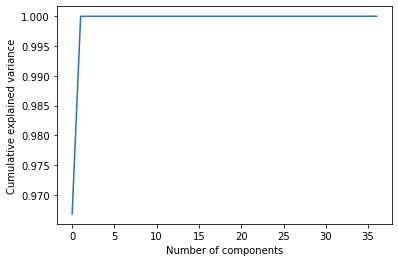

In [27]:
csv_name = "X"


if (include_kmeans):
    sep_DPMU_clusters_kmeans()
    csv_name = csv_name + "_kmeans"

if(include_PCA):
    sep_DPMU_clusters_PCA()
    csv_name = csv_name + "_pca"

if(include_phase):
    phase_clustering()
    csv_name = csv_name + "_phase"
    
if(include_holidays):
    add_holidays()
    csv_name = csv_name + "_holidays"
    
if(include_wknds):
    add_weekends()
    csv_name = csv_name + "_weekends"
    
if(include_dayofweek):
    add_dayofweek()
    csv_name = csv_name + "_weekdays"


In [28]:
csv_name

'X_pca'

In [29]:
in_csv

,0,1,2,3,4,5,6,7,8,9,...,175670,175671,175672,175673,175674,175675,175676,175677,175678,175679
0,0.990171,0.992045,0.990524,0.989491,0.989289,0.989027,0.989293,0.991238,0.990925,0.994143,...,0.99258,0.993063,0.992617,0.992406,0.993099,0.993186,0.993476,0.99503,0.995029,0.995397
1,0.990995,0.992832,0.991423,0.990348,0.990203,0.989965,0.99021,0.992155,0.991868,0.994842,...,0.992702,0.993189,0.992727,0.992532,0.9932,0.993312,0.993602,0.995148,0.995163,0.995531
2,0.983917,0.988117,0.985896,0.983449,0.983485,0.983148,0.983557,0.987032,0.986152,0.990435,...,0.983419,0.984449,0.983829,0.983532,0.984807,0.98534,0.98584,0.988813,0.989004,0.989526
3,0.982308,0.987145,0.984432,0.981654,0.981808,0.981463,0.981952,0.985563,0.984543,0.989018,...,0.982124,0.983242,0.982528,0.982282,0.983603,0.984129,0.98463,0.987593,0.98784,0.988383
4,0.984998,0.987146,0.985541,0.984776,0.984036,0.983679,0.984117,0.986046,0.985516,0.990135,...,0.991936,0.992394,0.991956,0.991741,0.99246,0.992414,0.992588,0.994081,0.99416,0.994479
5,0.990413,0.991902,0.990485,0.989431,0.989231,0.988977,0.989227,0.991277,0.991282,0.994875,...,0.993215,0.99369,0.993139,0.992957,0.993608,0.993641,0.993939,0.995543,0.995532,0.99594
6,0.989883,0.991177,0.989786,0.988723,0.988506,0.988264,0.988519,0.990589,0.990767,0.994721,...,0.993157,0.993636,0.993039,0.992864,0.993511,0.993524,0.993838,0.995479,0.995464,0.995893
7,0.98032,0.985171,0.981373,0.978045,0.978398,0.978174,0.9788,0.982644,0.981667,0.986278,...,0.980307,0.981461,0.98064,0.980423,0.981761,0.982278,0.982765,0.985702,0.985975,0.986576
8,0.983917,0.988117,0.985896,0.983449,0.983485,0.983148,0.983557,0.987032,0.986152,0.990435,...,0.983419,0.984449,0.983829,0.983532,0.984807,0.98534,0.98584,0.988813,0.989004,0.989526
9,0.983924,0.988076,0.985819,0.983377,0.983441,0.983103,0.983492,0.986989,0.986096,0.990394,...,0.983497,0.98456,0.983937,0.983627,0.984918,0.985447,0.985938,0.988776,0.988933,0.989448


In [30]:
csv_name = csv_name + ".csv"
in_csv.to_csv('../../data/input/' + csv_name)

# Output (Grid) Preprocessing (sends to Y.csv)

In [26]:
base_path_Player = "..\\..\\data\\summer\\input_csv"

In [27]:
def set_output():
    month_players = []
    for month in os.listdir(base_path_Player):
        month_path = os.path.join(base_path_Player,month)
        input_player_df = pd.DataFrame()
        for filename in os.listdir(month_path):
            if str(filename).startswith('25.csv'):
                continue
            player = pd.read_csv(os.path.join(month_path, filename))
            player['grid'] = player['grid'].str.replace("i", "j").apply(lambda x: complex(x))
            node_id = player['id'].loc[0]
            column_name_p = 'p_'+str(node_id)
            column_name_q = 'q_'+str(node_id)
        #change .head() value to target dataframe row number
            input_player_df[column_name_p] = player['grid'].apply(lambda x: x.real).head(44640)
            input_player_df[column_name_q] = player['grid'].apply(lambda x: x.imag).head(44640)
        month_players.append(input_player_df)
    output_dataframe_Player = pd.DataFrame() ##concatenates all months, directly to input
    output_dataframe_Player = pd.concat(month_players, ignore_index = True)
    return (output_dataframe_Player)
    
    

In [28]:
##input_dataframe_DPMU will have large dataframe of input data
send_targets_to_csv = pd.DataFrame()
send_targets_to_csv = set_output()

In [29]:
send_targets_to_csv

,p_1,q_1,p_10,q_10,p_11,q_11,p_12,q_12,p_13,q_13,...,p_5,q_5,p_6,q_6,p_7,q_7,p_8,q_8,p_9,q_9
0,43770.0,18273.479083,49815.0,19677.968025,6210.0,2993.529277,7680.0,2977.205699,61020.0,25629.453761,...,53790.0,22680.824631,67515.0,26725.875676,29070.0,12766.083147,6045.0,2538.376656,5310.0,1768.574303
1,43800.0,16056.165241,49830.0,21169.506826,6210.0,2503.047231,7410.0,3187.775742,60975.0,24463.259976,...,53640.0,18591.367838,67395.0,24229.587465,39240.0,16830.434105,6090.0,2080.689498,5295.0,1960.017239
2,43740.0,16725.190261,49980.0,18571.507872,6210.0,2406.866873,7410.0,3368.241776,95295.0,34245.168859,...,53670.0,17841.890713,67035.0,23688.227789,39525.0,14630.069312,6165.0,2053.104821,5265.0,2332.545638
3,43695.0,14533.893706,49920.0,21483.136368,6210.0,2552.831448,7410.0,2727.305834,111255.0,45610.401766,...,53565.0,25357.082993,67005.0,25112.807910,39675.0,15125.471091,8325.0,3691.961411,5280.0,1817.387203
4,43635.0,18926.971373,49875.0,19129.801554,6210.0,2285.612698,8385.0,2785.115072,105225.0,42562.705246,...,53520.0,24179.304713,67050.0,27466.505811,39645.0,16417.639968,7950.0,2996.814233,5265.0,2177.816589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175675,6465.0,2822.317617,45765.0,18524.166195,50505.0,22528.098381,8430.0,2789.272489,57450.0,25219.495588,...,4650.0,1807.317228,64635.0,27118.997672,4740.0,1824.514606,41190.0,13817.778604,6705.0,2637.722707
175676,7725.0,3085.881665,45735.0,20028.965065,24030.0,10193.354166,23640.0,10681.441361,57855.0,25297.044348,...,4635.0,1981.916417,62775.0,29347.144545,4725.0,1975.152094,39915.0,16853.690903,6645.0,2488.146655
175677,7650.0,3636.386829,45810.0,17385.362109,18000.0,6288.798710,38730.0,16854.617167,59265.0,23744.529706,...,4635.0,2003.650515,62595.0,29119.896786,3105.0,1308.767508,39375.0,18577.764183,6645.0,2787.186256
175678,7635.0,2981.949705,46065.0,18604.384766,8415.0,2868.802547,39315.0,18257.810943,58860.0,21173.453924,...,4620.0,1985.184652,61470.0,25781.111189,2745.0,1154.465979,39315.0,16184.443484,6645.0,3169.747109


In [30]:
send_targets_to_csv.to_csv('../../data/outputs/Y.csv')